# YOLO v11 Object Detection Tutorial

This notebook provides a comprehensive guide to using YOLO v11 for object detection tasks. YOLO (You Only Look Once) is a popular real-time object detection system, and v11 represents the latest advancement in the architecture with improved accuracy and speed.

## Contents
1. Installation and Setup
2. Loading the Model
3. Processing Images
4. Processing Video


## 1. Installation and Setup

First, let's install the necessary dependencies. YOLO v11 requires PyTorch, OpenCV, and other libraries.

In [31]:
# # Install dependencies
# !pip install torch torchvision torchaudio
# !pip install opencv-python
# !pip install ultralytics  # Latest package that includes YOLO v11
# !pip install matplotlib seaborn pandas

Let's import the necessary libraries:

In [32]:
import torch

import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import os
import pandas as pd
import seaborn as sns

# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Set plotting style
plt.style.use('fivethirtyeight')
%matplotlib inline

CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Laptop GPU


## 2. Loading the Model

YOLO v11 offers several model sizes to balance between speed and accuracy. Let's explore the available models and load our preferred version.

In [33]:
# List available YOLO v11 models
models = [
    'yolov11n',  # Nano - Smallest and fastest
    'yolov11s',  # Small
    'yolov11m',  # Medium
    'yolov11l',  # Large
    'yolov11x'   # Extra Large - Most accurate
]

print("Available YOLOv11 models:")
for i, model in enumerate(models):
    print(f"{i+1}. {model}")

Available YOLOv11 models:
1. yolov11n
2. yolov11s
3. yolov11m
4. yolov11l
5. yolov11x


In [34]:
from ultralytics import YOLO

# Load the YOLOv11 model
# Download link: https://docs.ultralytics.com/tasks/detect/
model = YOLO('/home/tang/FRA532_objectdetechtion/TrackingTask/yolo11n.pt')

# Display model information
print(f"Model: {model.model_name}")
print(f"Task: {model.task}")
print(f"Classes: {len(model.names)}")
print("Class names sample:", list(model.names.values())[:10])

Model: /home/tang/FRA532_objectdetechtion/TrackingTask/yolo11n.pt
Task: detect
Classes: 80
Class names sample: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light']


## 3. Processing Images

Now let's use our model to detect objects in images. We'll demonstrate with a sample image.

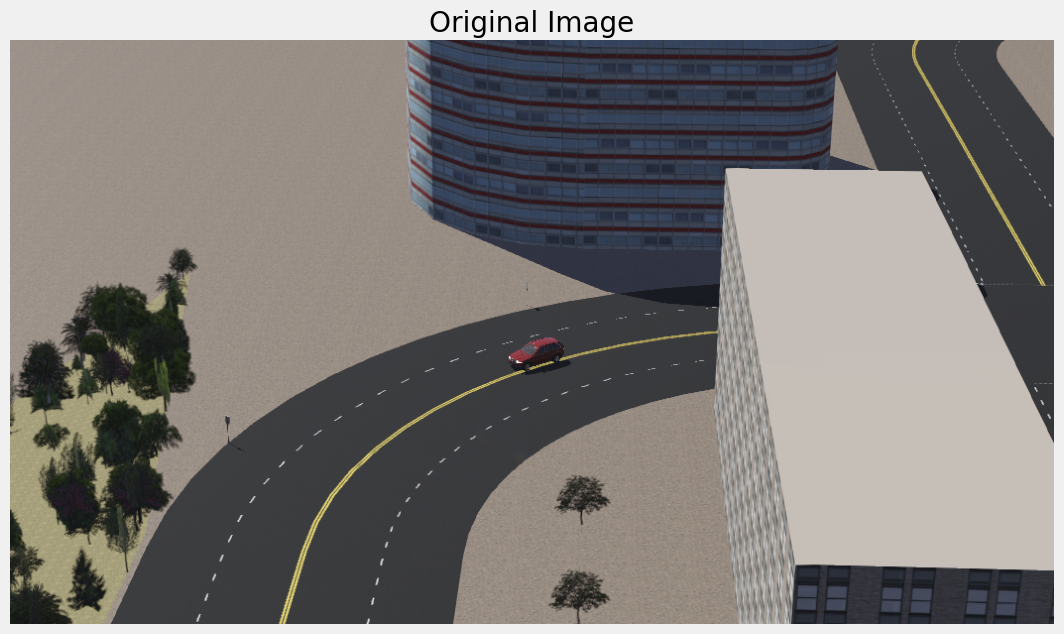

In [35]:
import cv2
import matplotlib.pyplot as plt
# Load the testing image
image_path = '/home/tang/FRA532_objectdetechtion/TrackingTask/car.png'

# Display the original image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [36]:
# Perform object detection
results = model(img_rgb)

# Parse the results
result = results[0]  # Get the first result
boxes = result.boxes  # Get the bounding boxes

# Display detection information
print(f"Detected {len(boxes)} objects")

# Create a DataFrame to display detection details
detections = []
for i, box in enumerate(boxes):
    class_id = int(box.cls)
    class_name = model.names[class_id]
    confidence = float(box.conf)
    x1, y1, x2, y2 = box.xyxy[0].tolist()  # Get box coordinates
    
    detections.append({
        'ID': i,
        'Class': class_name,
        'Confidence': f"{confidence:.2f}",
        'Coordinates': f"({int(x1)}, {int(y1)}, {int(x2)}, {int(y2)})"
    })

detections_df = pd.DataFrame(detections)
detections_df


0: 384x640 (no detections), 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Detected 0 objects


""


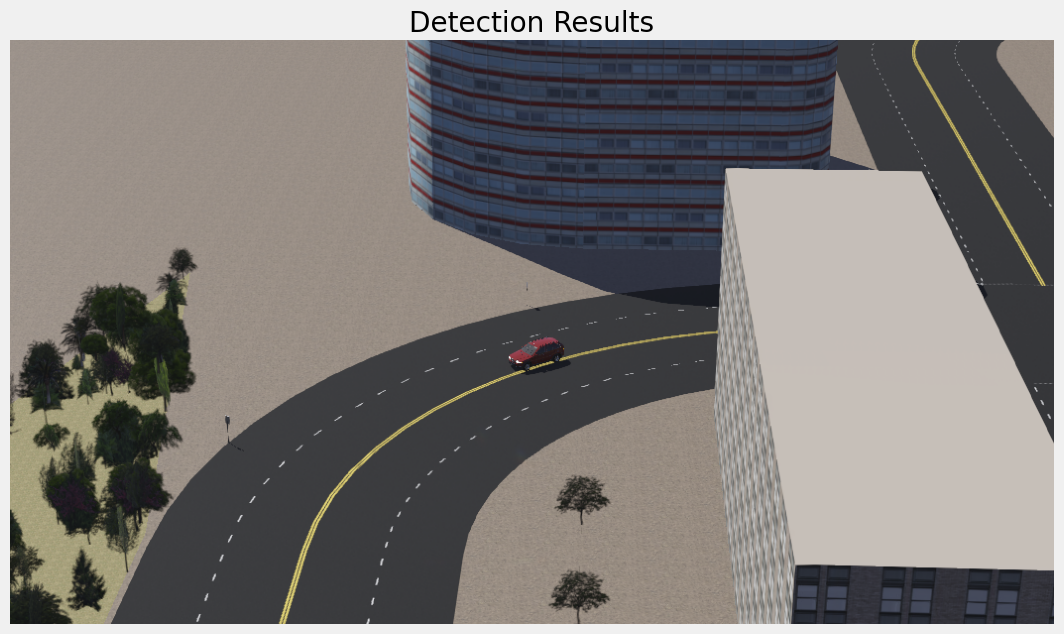

In [37]:
# Visualize the detection results
# Plot the image with bounding boxes and labels
def plot_results(image, boxes, names):
    img = image.copy()
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 10.0  # Bigger text
    font_thickness = 2

    for box in boxes:
        # Get box coordinates
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        
        # Get class and confidence
        class_id = int(box.cls)
        class_name = names[class_id]
        confidence = float(box.conf)
        
        # Create label text
        label = f"{class_name}: {confidence:.2f}"
        
        # Text size
        text_size, _ = cv2.getTextSize(label, font, font_scale, font_thickness)
        text_w, text_h = text_size

        # Color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        
        # Draw bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness=2)

        # Draw filled rectangle as text background
        cv2.rectangle(img, (x1, y1 - text_h - 10), (x1 + text_w, y1), color, thickness=-1)

        # Draw label text
        cv2.putText(img, label, (x1, y1 - 5), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)
        
    return img


# Plot the results
result_img = plot_results(img_rgb, boxes, model.names)

plt.figure(figsize=(12, 8))
plt.imshow(result_img)
plt.title('Detection Results')
plt.axis('off')
plt.show()

## 4. Processing Video

YOLO v11 can also process video streams efficiently. Let's see how to apply our model to video content.

In [38]:
# Define the path to your video file
video_path = '/home/tang/FRA532_objectdetechtion/video/moose_demo_1.mp4'

# Create output folder
output_folder = "detect_output2"
os.makedirs(output_folder, exist_ok=True)

# Create output video
output_path = "detect_output2_video.mp4"


# Function to process video
def process_video(video_path, output_path=output_path, confidence=0.5, every_n_frames=1):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Initialize counters
    frame_count = 0
    processed_count = 0
    
    # Process the video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Process every n-th frame to speed up processing
        if frame_count % every_n_frames == 0:
            # Convert frame from BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Perform detection
            results = model(frame_rgb, conf=confidence)
            
            # Get boxes
            boxes = results[0].boxes
            
            # Draw bounding boxes
            processed_frame = plot_results(frame_rgb, boxes, model.names)
            
            # Convert back to BGR for saving
            processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR)
            processed_count += 1
        else:
            processed_frame = frame
        
        # Save frame to output folder
        frame_filename = os.path.join(output_folder, f"frame_{frame_count}.jpg")
        cv2.imwrite(frame_filename, processed_frame)
        
        # Write the frame
        out.write(processed_frame)
        
        # Update counter
        frame_count += 1
        
        # Print progress
        if frame_count % 100 == 0:
            print(f"Processed {frame_count}/{total_frames} frames ({frame_count/total_frames*100:.1f}%)")
    
    # Release resources
    cap.release()
    out.release()
    
    print(f"Video processing complete. Processed {processed_count} out of {frame_count} frames.")
    print(f"Output saved to {output_path}")
    
    return output_path

In [39]:
# Process a short clip of the video for demonstration
# This will process every 3rd frame to speed up processing
output_video = process_video(video_path, confidence=0.5, every_n_frames=3)


0: 384x640 (no detections), 6.3ms
Speed: 1.3ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 5.8ms
Speed: 1.3ms preprocess, 5.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 5.9ms
Speed: 1.4ms preprocess, 5.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.3ms
Speed: 1.3ms preprocess, 6.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 5.9ms
Speed: 1.3ms preprocess, 5.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.3ms
Speed: 1.4ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.9ms 